In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler, LabelEncoder
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve,
    precision_recall_curve
)
import xgboost as xgb
from sklearn.compose import ColumnTransformer
import lightgbm as lgb


In [2]:
df=pd.read_csv('../data/final/Classification_table.csv')

In [3]:
df.shape

(264909, 44)

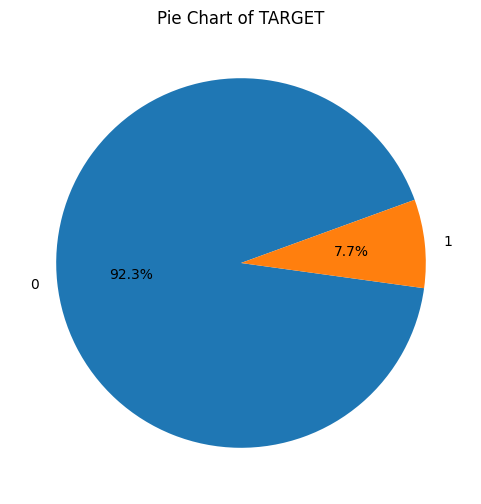

In [4]:
value_counts = df["TARGET"].value_counts()
top_n = 6
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
pie_data = value_counts.head(top_n)
axes.pie(
    pie_data,
    labels=pie_data.index.tolist(),
    autopct='%1.1f%%',
    startangle=20
)
axes.set_title('Pie Chart of TARGET')
plt.show()

In [5]:
final_features_classification = [

    # numeric (raw / ratios)
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',

    'Credit_to_Income_Ratio',
    'Annuity_to_Income_Ratio',
    'Annuity_to_Credit_Ratio',

    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',

    'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH',
    'DAYS_REGISTRATION',
    'DAYS_LAST_PHONE_CHANGE',
    'CNT_FAM_MEMBERS',
    'REGION_RATING_CLIENT',

    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',

    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_YEAR',

    'bureau_overdue_months',
    'total_active_bureau_loans',

    'pos_num_loans',
    'pos_mean_cnt_instalment',

    'inst_mean_payment_delay',
    'inst_mean_payment_rate',

    'avg_prev_amt_requested',
    'prev_num_approved',
    'prev_num_rejected',

    'max_cc_sk_dpd_def',
    'CC_PAYMENT_RATIO',
    'DELINQUENCY_SEVERITY',

    # binary flags
    'HAS_CC_DELINQUENCY',
    'NO_CC_PAYMENT_FLAG',

    # categorical (encode later)
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE',

    # target
    'TARGET'
]


In [6]:
y = df['TARGET']
X = df.drop(columns=['TARGET'])

In [7]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['number','int64','float64']).columns

Logistic Regression (baseline)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_val_cat = ohe.transform(X_val[cat_cols])

In [12]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_val_num = scaler.transform(X_val[num_cols])

In [13]:
X_train_final = pd.concat([
    pd.DataFrame(np.asarray(X_train_num), index=X_train.index),
    pd.DataFrame(np.asarray(X_train_cat), index=X_train.index)
], axis=1)

X_val_final = pd.concat([
    pd.DataFrame(np.asarray(X_val_num), index=X_val.index),
    pd.DataFrame(np.asarray(X_val_cat), index=X_val.index)
], axis=1)

In [14]:
model1 = LogisticRegression(max_iter=1000, class_weight='balanced')

In [15]:
mlflow.set_experiment("Target_Classification")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    model1.fit(X_train_final, y_train)

    preds = model1.predict_proba(X_val_final)[:,1]

    # metrics
    roc_auc = roc_auc_score(y_val, preds)
    pr_auc = average_precision_score(y_val, preds)
    precision = precision_score(y_val, model1.predict(X_val_final))
    recall = recall_score(y_val, model1.predict(X_val_final))
    f1 = f1_score(y_val, model1.predict(X_val_final))
    accuracy = accuracy_score(y_val, model1.predict(X_val_final))
    fpr, tpr, _ = roc_curve(y_val, preds)
    ks = np.max(tpr - fpr)

    mlflow.log_param("model_type", "LogesticRegression")
    mlflow.log_param("features_count", X.shape[1])

    mlflow.log_metric("roc_auc", float(roc_auc))
    mlflow.log_metric("pr_auc", float(pr_auc))
    mlflow.log_metric("precision", float(precision))
    mlflow.log_metric("recall", float(recall))
    mlflow.log_metric("f1", float(f1))
    mlflow.log_metric("accuracy", float(accuracy))
    mlflow.log_metric("ks_statistic", float(ks))

    mlflow.sklearn.log_model(
        model1,
        artifact_path="model"
    )


2025/12/17 18:27:36 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/17 18:27:36 INFO mlflow.store.db.utils: Updating database tables
2025/12/17 18:27:36 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 18:27:36 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/17 18:27:36 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 18:27:36 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/17 18:27:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run worried-gnu-979 at: http://127.0.0.1:5000/#/experiments/2/runs/ab0cf2bf9358494492fcf08f5ff049d0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


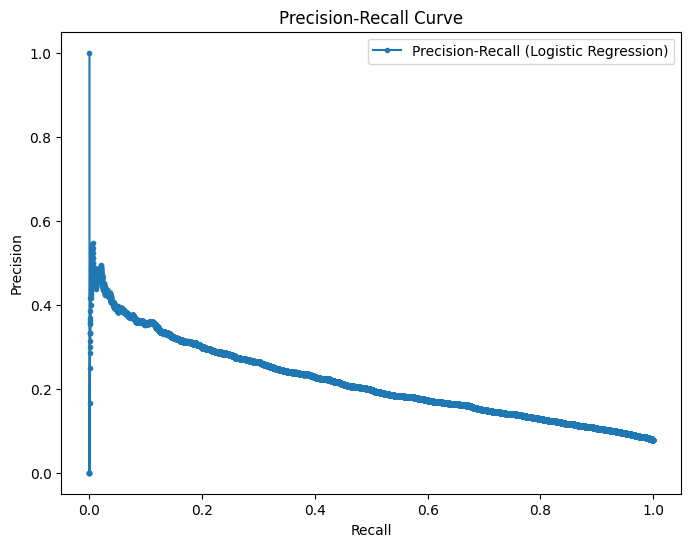

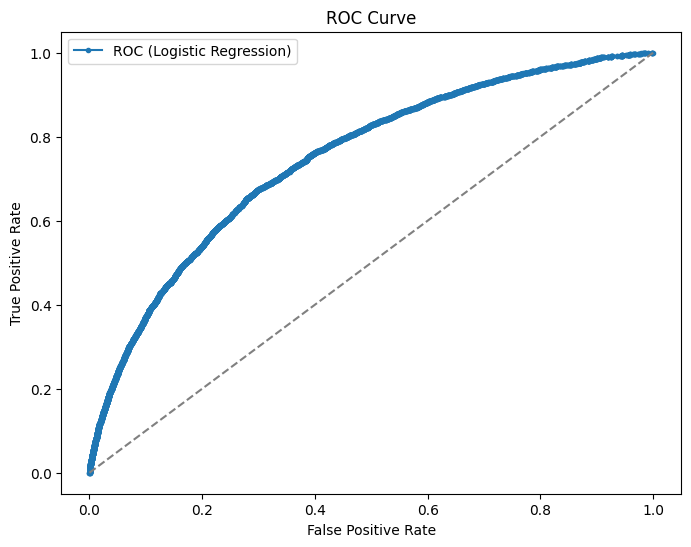

In [16]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_val, preds)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall (Logistic Regression)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='ROC (Logistic Regression)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

XGBOOST

In [6]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols)
    ],
    remainder="passthrough"
)

In [9]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

In [10]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

In [11]:
model2 = xgb.XGBClassifier(
    n_estimators=2300,
    learning_rate=0.018,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,   
    reg_lambda=2.0,  
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

In [12]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("Target_Classification")

with mlflow.start_run():

    # train (XGBoost already supports early stopping via eval_set)
    model2.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )

    # probabilities
    y_proba = model2.predict_proba(X_val)[:, 1]

    # threshold (keep explicit)
    threshold = 0.25
    y_pred = (y_proba >= threshold).astype(int)

    # metrics
    roc_auc = roc_auc_score(y_val, y_proba)
    pr_auc = average_precision_score(y_val, y_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    # KS statistic
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    ks = np.max(tpr - fpr)

    # log params
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("features_count", X_train.shape[1])
    mlflow.log_param("threshold", threshold)

    # log metrics
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("pr_auc", pr_auc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("ks_statistic", ks)

    # log model
    mlflow.xgboost.log_model(
        model2,
        artifact_path="model"
    )

[0]	validation_0-auc:0.70193
[100]	validation_0-auc:0.73650
[200]	validation_0-auc:0.75009
[300]	validation_0-auc:0.75671
[400]	validation_0-auc:0.76023
[500]	validation_0-auc:0.76251
[600]	validation_0-auc:0.76400
[700]	validation_0-auc:0.76529
[800]	validation_0-auc:0.76641
[900]	validation_0-auc:0.76730
[1000]	validation_0-auc:0.76788
[1100]	validation_0-auc:0.76842
[1200]	validation_0-auc:0.76873
[1300]	validation_0-auc:0.76923
[1400]	validation_0-auc:0.76961
[1500]	validation_0-auc:0.76990
[1600]	validation_0-auc:0.77005
[1700]	validation_0-auc:0.77019
[1800]	validation_0-auc:0.77040
[1900]	validation_0-auc:0.77048
[2000]	validation_0-auc:0.77040
[2100]	validation_0-auc:0.77057
[2200]	validation_0-auc:0.77057
[2299]	validation_0-auc:0.77054


2025/12/17 18:58:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run redolent-flea-134 at: http://127.0.0.1:5000/#/experiments/2/runs/5d090df111a84fbe99851ce0df7a49be
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


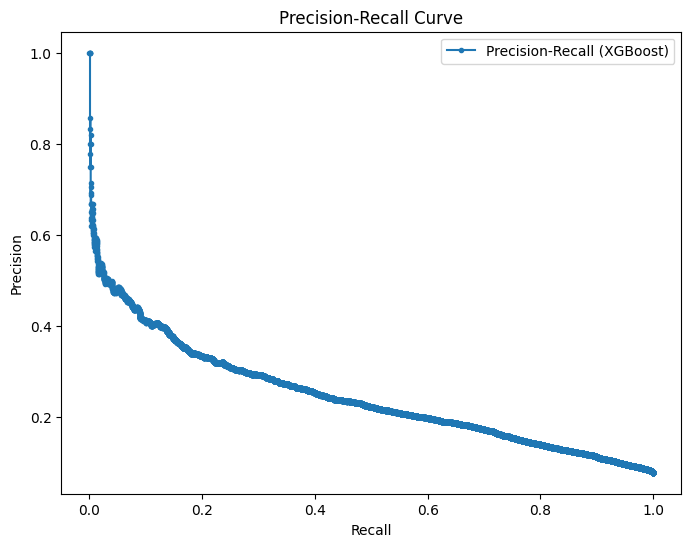

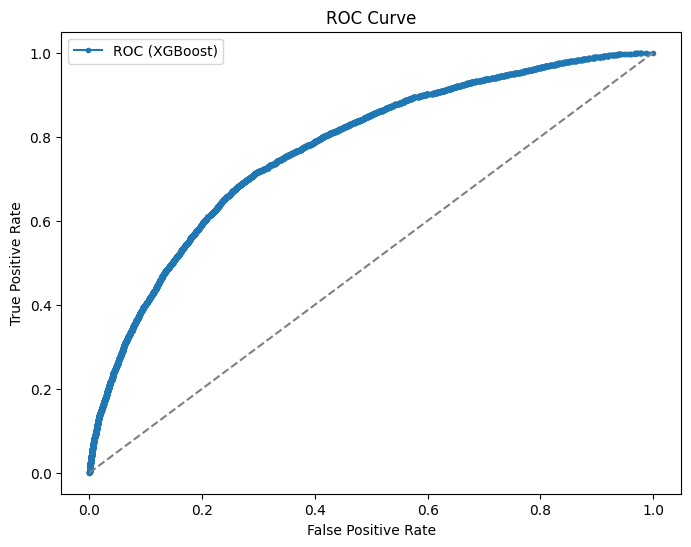

In [13]:
# Precision-Recall Curve for XGBoost
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall (XGBoost)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve for XGBoost
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='ROC (XGBoost)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

LightGBM

In [44]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [45]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [46]:
cat_cols = X_train.select_dtypes(include=['object','category']).columns

label_encoders = {}

for col in cat_cols:
    # ensure string
    X_train[col] = X_train[col].astype(str)
    X_val[col]   = X_val[col].astype(str)

    # most frequent category from TRAIN only (no leakage)
    most_freq = X_train[col].mode()[0]

    # fill missing
    X_train[col] = X_train[col].fillna(most_freq)
    X_val[col]   = X_val[col].fillna(most_freq)

    # fit encoder on train
    le = LabelEncoder()
    le.fit(X_train[col])

    # map unseen categories in validation to most frequent
    X_val[col] = X_val[col].apply(
        lambda x: x if x in le.classes_ else most_freq
    )

    # transform
    X_train[col] = le.transform(X_train[col])
    X_val[col]   = le.transform(X_val[col])

    label_encoders[col] = le

In [56]:
model3 = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",

    # core learning
    n_estimators=6000,
    learning_rate=0.0018,
    num_leaves=128,
    min_child_samples=150,
    max_depth=-1,

    # regularization (very important)
    
    min_split_gain=0.1,        # gamma equivalent
    reg_alpha=1.0,
    reg_lambda=2.0,

    # sampling
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,

    # imbalance handling
    scale_pos_weight=scale_pos_weight,

    # misc
    random_state=42,
    n_jobs=-1
)


In [57]:
assert len(X_train.select_dtypes(include=['object','category']).columns) == 0
assert len(X_val.select_dtypes(include=['object','category']).columns) == 0

In [58]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("Target_Classification")

with mlflow.start_run():
    # train with early stopping
    model3.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)]

    )
    y_proba = model3.predict_proba(
        X_val,
        num_iteration=model3.best_iteration_
    )
    y_proba = y_proba[:, 1]

    # explicit threshold
    threshold = 0.05
    y_pred = (y_proba >= threshold).astype(int)

    # metrics
    roc_auc = roc_auc_score(y_val, y_proba)
    pr_auc = average_precision_score(y_val, y_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    # KS statistic
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    ks = np.max(tpr - fpr)

    # log params
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_param("features_count", X_train.shape[1])
    mlflow.log_param("threshold", threshold)
    mlflow.log_param("best_iteration", model3.best_iteration_)

    # log metrics
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("pr_auc", pr_auc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("ks_statistic", ks)

    # log model
    mlflow.lightgbm.log_model(
        model3,
        artifact_path="model"
    )
print("Positive predictions:", y_pred.sum())
print("Mean proba:", y_proba.mean())
print("Max proba:", y_proba.max())


[LightGBM] [Info] Number of positive: 16392, number of negative: 195535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4897
[LightGBM] [Info] Number of data points in the train set: 211927, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077347 -> initscore=-2.478946
[LightGBM] [Info] Start training from score -2.478946
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	valid_0's auc: 0.744883	valid_0's binary_logloss: 0.268041


2025/12/17 19:22:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run adaptable-bug-709 at: http://127.0.0.1:5000/#/experiments/2/runs/1c87a95636e248719a446cda63ce00ec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
Positive predictions: 52982
Mean proba: 0.1000843038997276
Max proba: 0.12836110068633438
